In [132]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard
import sklearn as sk
import tensorflow as tf
import tensorflow_hub as hub

Constantes a definir

In [2]:
RUTA = "./tfg_dataset"
DIM = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = .2

Funciones para visualizar un ejemplo del dataset creado con `image_dataset_from_directory` y con `flow_from_directory`

In [3]:
def sample_ds_dfd(ds): 
    for i, (img, label) in enumerate(ds.take(9)): 
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[0].numpy())
        plt.title(ds.class_names[np.argmax(label)])
        plt.axis("off")

def sample_ds_ffd(ds): 
    for i, (img, label) in enumerate(zip(ds[0][0], ds[0][1])):
        if i == 9: break
        plt.subplot(3, 3, i + 1)
        plt.title(dict(zip(ds.class_indices.values(), ds.class_indices.keys()))[np.argmax(label)])
        plt.imshow(img)
        plt.axis("off")

Se crea un dataset con todas las imágenes del directorio. Se elige un tamaño de batch, pero al entrenar se puede especificar otro (utiliza el menor de los dos). 

In [6]:
x_train, x_val = image_dataset_from_directory(
    directory = RUTA,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

Found 624 files belonging to 5 classes.
Using 500 files for training.
Using 124 files for validation.


Se normalizan los valores de las imágenes para facilitar el trabajo a la red

In [7]:
class_names = x_train.class_names
norm = tf.keras.layers.Rescaling(1./255)
x_train = x_train.map(lambda x, y: (norm(x), y))
x_val = x_val.map(lambda x, y: (norm(x), y))
x_train.class_names = class_names
x_val.class_names = class_names

Se muestran algunos ejemplos del dataset

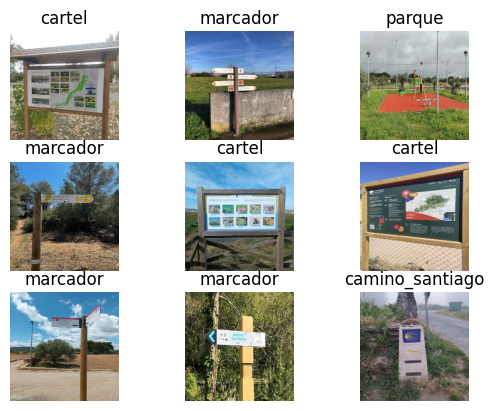

In [8]:
sample_ds_dfd(x_train)

Se crea un modelo basado en uno ya entrenado de TensorHub

In [9]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
red_hub = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_hub.summary()
red_hub.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________



Se realiza el entrenamiento del modelo

In [10]:
%load_ext tensorboard
red_hub.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [TensorBoard(log_dir = "logs")])

Epoch 1/25



16/16 [==============================] - 9s 287ms/step - loss: 1.1518 - accuracy: 0.5500 - val_loss: 0.5971 - val_accuracy: 0.8306
Epoch 2/25
16/16 [==============================] - 5s 255ms/step - loss: 0.4399 - accuracy: 0.8900 - val_loss: 0.2676 - val_accuracy: 0.9597
Epoch 3/25
16/16 [==============================] - 5s 249ms/step - loss: 0.2564 - accuracy: 0.9340 - val_loss: 0.1600 - val_accuracy: 0.9839
Epoch 4/25
16/16 [==============================] - 5s 248ms/step - loss: 0.1781 - accuracy: 0.9640 - val_loss: 0.1227 - val_accuracy: 0.9839
Epoch 5/25
16/16 [==============================] - 5s 248ms/step - loss: 0.1376 - accuracy: 0.9820 - val_loss: 0.1042 - val_accuracy: 0.9919
Epoch 6/25
16/16 [==============================] - 5s 249ms/step - loss: 0.1113 - accuracy: 0.9780 - val_loss: 0.0909 - val_accuracy: 0.9839
Epoch 7/25
16/16 [==============================] - 5s 248ms/step - loss: 0.0913 - accuracy: 0.9900 - val_loss: 0.0853 - val_accuracy: 0.9839
Epoch 8/25
16/16 

Se hacen las predicciones sobre el conjunto de test para evaluar el modelo

In [164]:
def predict_dataset(ds, modelo): 
    y_target = []
    y_hat = []
    batches = len(ds)
    for batch, (img_batch, label_batch) in enumerate(ds): 
        if batch == batches: 
            break
        else: 
            for img, label in zip(img_batch, label_batch):
                y_target.append(np.argmax(label))
                y_hat.append(np.argmax(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)[0]))
    return np.column_stack((y_target, y_hat)), modelo.predict(ds, verbose = 0)

Y_matrix, y_score = predict_dataset(x_val, red_hub)

Se muestran las 9 primeras predicciones como ejemplo

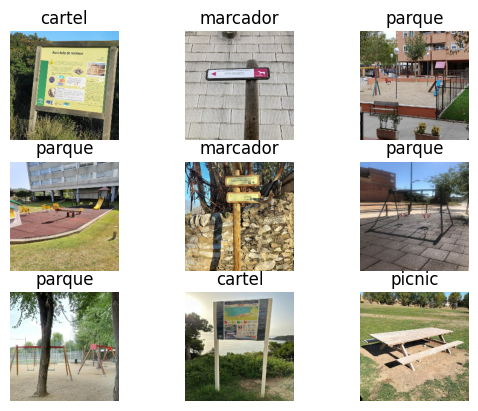

In [165]:
def sample_predict_ds_fd(ds, Y_matrix): 
    batch = next(iter(ds.take(1)))
    for i in range(9): 
        prediccion = Y_matrix[i, 1]
        plt.subplot(3, 3, i + 1)
        plt.title(ds.class_names[prediccion])
        plt.imshow(batch[0][i].numpy())
        plt.axis("off")

sample_predict_ds_fd(x_val, Y_matrix)

### Métricas
¿Realmente ha sido un buen modelo? 
#### Matriz de confusión

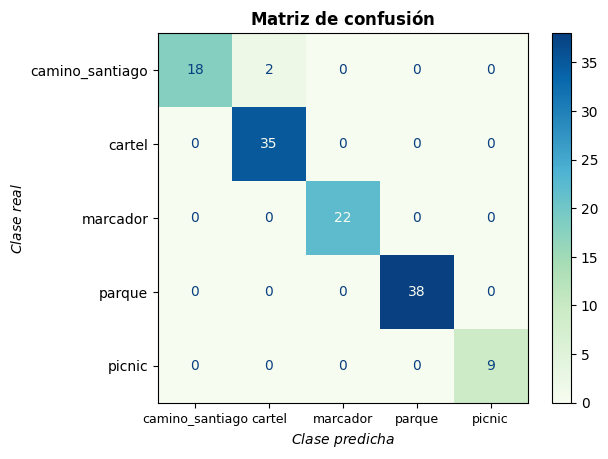

In [166]:
def matriz_confusion(ds, Y_matrix): 
    cm = sk.metrics.confusion_matrix(Y_matrix[:, 0], Y_matrix[:, 1])
    diagrama = sk.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ds.class_names).plot(
        include_values = True, 
        cmap = plt.cm.GnBu, 
        ax = plt.gca()
    )
    diagrama.ax_.set_title(r"$\mathbf{Matriz\ de\ confusión}$")
    diagrama.ax_.set_xlabel(r"$\mathit{Clase\ predicha}$")
    diagrama.ax_.set_ylabel(r"$\mathit{Clase\ real}$")
    diagrama.ax_.tick_params(axis = "x", labelsize = 9)

matriz_confusion(x_val, Y_matrix)

#### Resumen de métricas

* **Precisión**: de todos los elementos clasificados como $C_i$, ¿cuántos realmente pertenecen a dicha clase?
$$
\mathcal{P} = P(C_i | \hat{C}_i) = \frac{P(C_i \cap \hat{C}_i)}{P(\hat{C}_i)}
$$

* **Sensibilidad**: de todos los elementos de la clase $C_i$, ¿cuántos se han clasificado como tal?
$$
\mathcal{R} = P(\hat{C}_i | C_i) = \frac{P(\hat{C}_i \cap C_i)}{P(C_i)}
$$

* $F_1-$ Score: en general, ¿cómo de bueno es el clasificador?
$$
F_1 = \frac{2}{\mathcal{P}^{-1} + \mathcal{R}^{-1}}
$$

In [189]:
def metricas_matriz_confusion(ds, Y_matrix, dict = False):
    return sk.metrics.classification_report(
                                 Y_matrix[:, 0], Y_matrix[:, 1], 
                                 target_names = ds.class_names, 
                                 digits = 3, 
                                 output_dict = dict
                                )

print(metricas_matriz_confusion(x_val, Y_matrix))

                 precision    recall  f1-score   support

camino_santiago      1.000     0.900     0.947        20
         cartel      0.946     1.000     0.972        35
       marcador      1.000     1.000     1.000        22
         parque      1.000     1.000     1.000        38
         picnic      1.000     1.000     1.000         9

       accuracy                          0.984       124
      macro avg      0.989     0.980     0.984       124
   weighted avg      0.985     0.984     0.984       124



* Coeficiente $\kappa$ de Cohen: otra manera de medir la calidad del clasificador. 

In [168]:
def kappa_cohen(Y_matrix): 
    return sk.metrics.cohen_kappa_score(Y_matrix[:, 0], Y_matrix[:, 1]).round(3)

kappa_cohen(Y_matrix)

0.979

* Curvas ROC y área AUC

In [169]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], y_score, multi_class = "ovo")

1.0

Se pueden asociar todas en una única función por comodidad: 

In [190]:
def metricas_prediccion(ds, Y_matrix, y_score): 
    matriz_confusion(ds, Y_matrix)
    print(metricas_matriz_confusion(ds, Y_matrix))
    print(f"Kappa de Cohen: {kappa_cohen(Y_matrix)}")
    print(f"AUC: {sk.metrics.roc_auc_score(Y_matrix[:, 0], y_score, multi_class = 'ovo').round(3)}")

Se va a proceder a la técnica del aumento de datos. (Por ahora probamos a cargar con esta otra función sin modificar las imágenes). 

In [170]:
generador_original = ImageDataGenerator(
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

generador_modificado = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 10,
    zoom_range = [0.25, 1.25],
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

x_train_2 = generador_original.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_2 = generador_original.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

x_train_au = generador_modificado.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_au = generador_modificado.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

Found 501 images belonging to 5 classes.


Found 123 images belonging to 5 classes.
Found 501 images belonging to 5 classes.
Found 123 images belonging to 5 classes.


Se muestran las imágenes modificadas

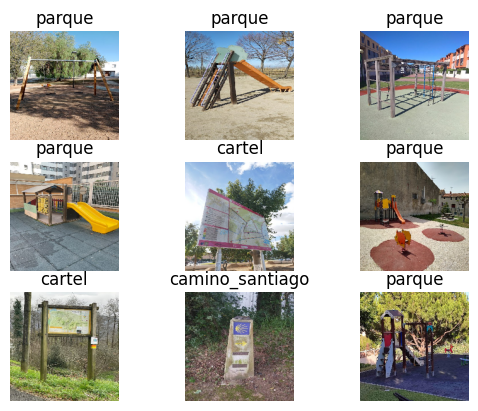

In [171]:
sample_ds_ffd(x_train_2)

Ahora se crea un modelo igual para entrenarlo y comprobar si esta técnica aporta diferencias al entrenamiento

In [172]:
red_hub_au = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_hub_au.summary()
red_hub_au.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Entrenamos el modelo

In [173]:
%load_ext tensorboard
red_hub_au.fit(x_train_2, epochs = 25, validation_data = x_val_2, callbacks = [TensorBoard(log_dir = "logs")])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/25
16/16 [==============================] - 12s 571ms/step - loss: 1.3411 - accuracy: 0.5070 - val_loss: 0.6540 - val_accuracy: 0.8049
Epoch 2/25
16/16 [==============================] - 7s 425ms/step - loss: 0.5460 - accuracy: 0.8443 - val_loss: 0.2897 - val_accuracy: 0.9350
Epoch 3/25
16/16 [==============================] - 7s 426ms/step - loss: 0.2919 - accuracy: 0.9361 - val_loss: 0.1636 - val_accuracy: 0.9837
Epoch 4/25
16/16 [==============================] - 7s 413ms/step - loss: 0.2015 - accuracy: 0.9561 - val_loss: 0.1280 - val_accuracy: 0.9675
Epoch 5/25
16/16 [==============================] - 7s 417ms/step - loss: 0.1570 - accuracy: 0.9681 - val_loss: 0.1064 - val_accuracy: 0.9837
Epoch 6/25
16/16 [==============================] - 7s 410ms/step - loss: 0.1246 - accuracy: 0.9780 - val_loss: 0.0971 - val_accuracy: 0.9675
Epoch 7/25
16/16 [==============================] - 7s 42

Aunque en este caso se tenían resultados buenos, ayuda a mejorar. Mediante las diferentes métricas, vemos que es perfecto en cuanto al conjunto de test empleado. 

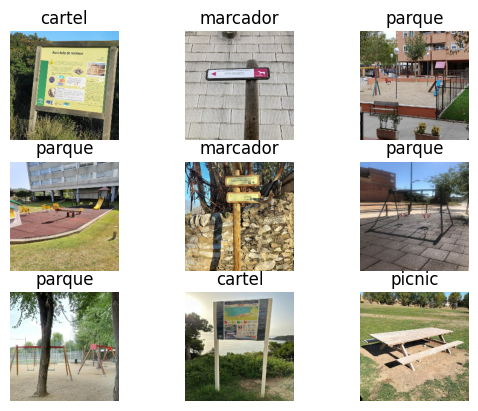

In [185]:
Y_matrix_au, y_score_au = predict_dataset(x_val, red_hub_au)
sample_predict_ds_fd(x_val, Y_matrix_au)

                 precision    recall  f1-score   support

camino_santiago      1.000     1.000     1.000        20
         cartel      1.000     1.000     1.000        35
       marcador      1.000     1.000     1.000        22
         parque      1.000     1.000     1.000        38
         picnic      1.000     1.000     1.000         9

       accuracy                          1.000       124
      macro avg      1.000     1.000     1.000       124
   weighted avg      1.000     1.000     1.000       124

Kappa de Cohen: 1.0
AUC: 1.0


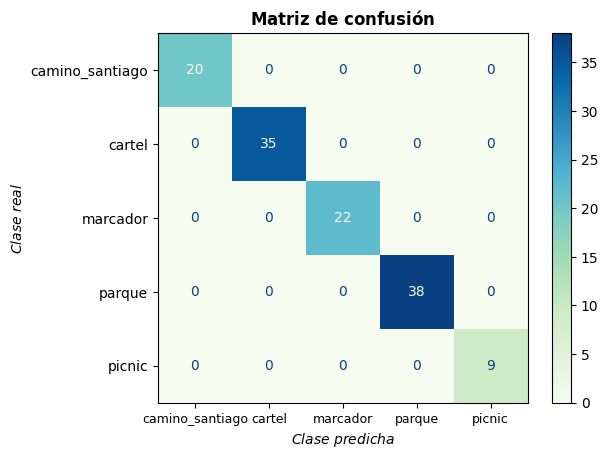

In [191]:
metricas_prediccion(x_val, Y_matrix_au, y_score_au)

Ahora se puede hacer una comparación rápida de cómo las técnicas de transfer learning dan unos resultados mucho mejores. 

In [199]:
red_conv = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_conv.summary()
red_conv.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 173056)           

In [200]:
%load_ext tensorboard
red_conv.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [TensorBoard(log_dir = "logs")])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/25
16/16 [==============================] - 8s 390ms/step - loss: 2.7292 - accuracy: 0.3020 - val_loss: 1.3736 - val_accuracy: 0.4597
Epoch 2/25
16/16 [==============================] - 7s 380ms/step - loss: 1.1886 - accuracy: 0.5700 - val_loss: 1.1825 - val_accuracy: 0.5645
Epoch 3/25
16/16 [==============================] - 7s 379ms/step - loss: 0.8962 - accuracy: 0.6780 - val_loss: 0.9985 - val_accuracy: 0.6371
Epoch 4/25
16/16 [==============================] - 7s 381ms/step - loss: 0.6761 - accuracy: 0.7680 - val_loss: 0.9541 - val_accuracy: 0.6532
Epoch 5/25
16/16 [==============================] - 7s 378ms/step - loss: 0.4579 - accuracy: 0.8640 - val_loss: 0.9052 - val_accuracy: 0.7016
Epoch 6/25
16/16 [==============================] - 7s 381ms/step - loss: 0.2804 - accuracy: 0.9060 - val_loss: 0.9069 - val_accuracy: 0.6935
Epoch 7/25
16/16 [==============================] - 7s 377

                 precision    recall  f1-score   support

camino_santiago      1.000     0.900     0.947        20
         cartel      0.763     0.829     0.795        35
       marcador      0.700     0.318     0.438        22
         parque      0.648     0.921     0.761        38
         picnic      1.000     0.444     0.615         9

       accuracy                          0.750       124
      macro avg      0.822     0.682     0.711       124
   weighted avg      0.772     0.750     0.733       124

Kappa de Cohen: 0.662
AUC: 0.909


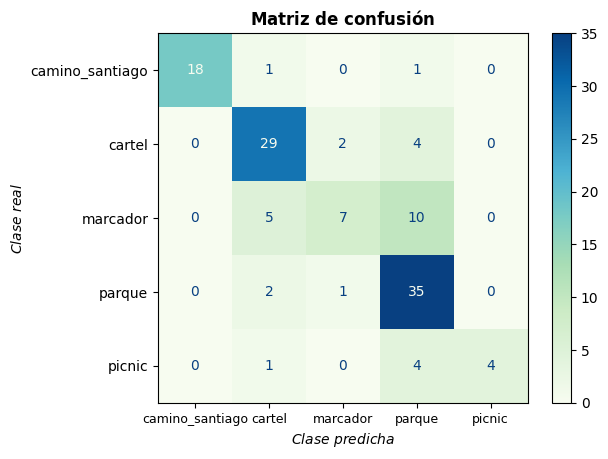

In [201]:
Y_matrix_conv, y_score_conv = predict_dataset(x_val, red_conv)
metricas_prediccion(x_val, Y_matrix_conv, y_score_conv)

Se nota que es peor, además de un claro sobreajuste en el entrenamiento, y que este es más costoso. Aún así para haberlo entrenado de cero y teniendo tan pocos datos, no está mal. 